# _Who has a voice in the media?_

## 1. Pre-processing the dataset
In this study of "_Who has a voice in the media_", the **speaker identity and what it said is vital**. Thus, we remove the following rows from the original dataset:
- rows where either the author or the quotation is NaN; 
- rows where the author has probability lower than 50%. 

Later, we also do a sanity controll and **remove possible duplicate of rows** with the same quote-ID as we obiously don't want to use exactly the same quote more than once in our analyzes. 

Finally, to reduce the dataset further we **remove columns** that we will not use for our analysis: _quoteID_, _speaker_, _probas_, _urls_, _phase_ and _numOccurrences_.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from pathlib import Path

## 2. Initial analysis
Here, we do initial studies on the content of the dataset. For instance we plot the following information about the speakers:
- occupation;
- gender;
- age;
- ethnicity;
- top 20 speakers.
**OBS! For practical reasons, in the initial analysis in Milestone 2, we randomly picked 100,000 quotations of each year instead of dealing with the whole data. The code and the analysis will basically remain the same but only need to be run for a longer time.**

In [2]:
datafolder = Path("data")

DATA = {
    '2015': 'data/clean-quotes-2015.bz2',
    '2016': 'data/clean-quotes-2016.bz2',
    '2017': 'data/clean-quotes-2017.bz2',
    '2018': 'data/clean-quotes-2018.bz2',
    '2019': 'data/clean-quotes-2019.bz2',
    '2020': 'data/clean-quotes-2020.bz2',
}

ALL_YEARS = ['2015', '2016', '2017', '2018', '2019', '2020']

def load_data(year, sample=True, sample_size=100_000):
    year_file = Path(DATA[year])
    if year_file.exists():
        df = pd.read_csv(DATA[year], compression='bz2')
        if sample:
            df = df.sample(n=sample_size, random_state=1)
    else:
        return None 
    
wikidata_speakers = pd.read_parquet('data/speaker_attributes.parquet')
wikidata_speakers.set_index('id', inplace=True)

In [3]:
nrows = 10_000
df = pd.read_csv(DATA['2020'], compression='bz2', nrows=nrows)

In [4]:
qids = df.qids.tolist()
wanted_qids = [eval(qid)[0] for qid in qids if len(eval(qid)) == 1 and eval(qid)[0] in wikidata_speakers.index]
speakers = wikidata_speakers.loc[wanted_qids]
speakers = speakers[~speakers.index.duplicated(keep='first')]

n_quotes_per_person = Counter(wanted_qids)
speakers['n_quotes'] = speakers.index.map(n_quotes_per_person)

ages = []
for date in speakers.date_of_birth.values:
    if not date is None:
        ages.append(datetime.now().year - int(date[0][1:5]))
    else:
        ages.append(None)

speakers['age'] = ages


### 3. Pre-process dataset
- Only keep meaningful features

In [11]:
print(f'The percentage of speakers with US_congress_bio_ID is {100 * len(speakers.US_congress_bio_ID.value_counts().index) / len(speakers.index) :.3f}%')
print(f'The percentage of speakers with candidacy is {100 * sum(speakers.candidacy.value_counts().values) / len(speakers.index):.3f}%')
print(f'The percentage of speakers with ethnic_group is {100 * sum(speakers.ethnic_group.value_counts().values) / len(speakers.index):.3f}%')
print(f'The percentage of speakers with religion is {100 * sum(speakers.religion.value_counts().values) / len(speakers.index):.3f}%')
print(f'The percentage of speakers with academic_degree is {100 * sum(speakers.academic_degree.value_counts().values) / len(speakers.index):.3f}%')
print(f'The percentage of speakers with party is {100 * sum(speakers.party.value_counts().values) / len(speakers.index):.3f}%')
print(f'The percentage of speakers with nationality is {100 * sum(speakers.nationality.value_counts().values) / len(speakers.index):.3f}%')
print(f'The percentage of speakers with gender is {100 * sum(speakers.gender.value_counts().values) / len(speakers.index):.3f}%')
print(f'The percentage of speakers with occupation is {100 * sum(speakers.occupation.value_counts().values) / len(speakers.index):.3f}%')

The percentage of speakers with US_congress_bio_ID is 2.665%
The percentage of speakers with candidacy is 4.705%
The percentage of speakers with ethnic_group is 7.480%
The percentage of speakers with religion is 11.009%
The percentage of speakers with academic_degree is 2.261%
The percentage of speakers with party is 23.378%
The percentage of speakers with nationality is 84.047%
The percentage of speakers with gender is 98.511%
The percentage of speakers with occupation is 96.526%


Drop the columns:
- that are particular to the speaker and don't add any value to the clustering (alisaes, label, US_congress_ID) ;
- that don't add value to clustering (lastrevid, type);
- that contain too little data to draw any conclusions (candidacy - 2.9%, academic_degree - 1.3%);
- used to produce the new ages column (date_of_birth). 

In [12]:
speakers_features = speakers.drop(columns=['aliases', 'label', 'US_congress_bio_ID', 
                                           'lastrevid', 'type', 
                                           'candidacy', 'academic_degree',
                                           'date_of_birth', 'religion'])
speakers_features.head()

,nationality,gender,ethnic_group,occupation,party,n_quotes,age
id,,,,,,,
Q367796,[Q30],[Q6581072],None,[Q82955],[Q29468],1,80.0
Q20684375,None,[Q6581072],None,None,None,2,37.0
Q5268447,[Q23635],[Q6581097],None,[Q12299841],None,1,60.0
Q4864119,None,[Q6581097],None,None,[Q9630],1,NaN
Q816459,[Q30],[Q6581097],[Q49085],"[Q212980, Q9385011, Q82955, Q482980, Q1622272,...","[Q29468, Q29552, Q327591, Q29468]",1,70.0


More pre-processing: make the None names to 'Unknown', otherwise the KPrototype doesn't run. This way, the 'Unknown' class becomes a categorical variable.

In [13]:
speakers_features_preprocessed = pd.DataFrame()
speakers_features_preprocessed['n_quotes'] = speakers_features['n_quotes']
speakers_features_preprocessed['age'] = speakers_features['age'].fillna(speakers_features['age'].median())

for name, values in speakers_features.iteritems():
    # Remove all None values from categorical rows, and keep only first instance of list occupation, nationality
    if name not in ['n_quotes', 'age']:
        updated_values = []
        for val in values:
            if not val is None:
                updated_values.append(val[0])
            else:
                updated_values.append('Unknown')
        speakers_features_preprocessed[name] = updated_values
    

In [14]:
speakers_features_preprocessed.head()

,n_quotes,age,nationality,gender,ethnic_group,occupation,party
id,,,,,,,
Q367796,1,80.0,Q30,Q6581072,Unknown,Q82955,Q29468
Q20684375,2,37.0,Unknown,Q6581072,Unknown,Unknown,Unknown
Q5268447,1,60.0,Q23635,Q6581097,Unknown,Q12299841,Unknown
Q4864119,1,52.0,Unknown,Q6581097,Unknown,Unknown,Q9630
Q816459,1,70.0,Q30,Q6581097,Q49085,Q212980,Q29468


In [15]:
assert(speakers_features_preprocessed.n_quotes.isna().sum() == 0)
assert(speakers_features_preprocessed.age.isna().sum() == 0)
assert(speakers_features_preprocessed.nationality.isna().sum() == 0)
assert(speakers_features_preprocessed.gender.isna().sum() == 0)
assert(speakers_features_preprocessed.ethnic_group.isna().sum() == 0)
assert(speakers_features_preprocessed.occupation.isna().sum() == 0)
assert(speakers_features_preprocessed.party.isna().sum() == 0)
# assert(speakers_features_preprocessed.religion.isna().sum() == 0)

In [16]:
speakers_features_full = pd.DataFrame()
speakers_features_full['n_quotes'] = speakers_features['n_quotes']
speakers_features_full['age'] = speakers_features['age'].fillna(speakers_features['age'].median()) # Fill the unknown ages with the median of the ages

for name, values in speakers_features.iteritems():
    # Remove all None values from categorical rows, and keep only first instance of list occupation, nationality
    if name not in ['n_quotes', 'age']:
        updated_values = []
        for val in values:
            if not val is None:
                updated_values.append(val[0])
            else:
                updated_values.append(None)
        speakers_features_full[name] = updated_values

In [17]:
speakers_features_preprocessed = speakers_features_full.drop(columns=['ethnic_group', 'party']).dropna(axis=0)

speakers_features_preprocessed.head()

,n_quotes,age,nationality,gender,occupation
id,,,,,
Q367796,1,80.0,Q30,Q6581072,Q82955
Q5268447,1,60.0,Q23635,Q6581097,Q12299841
Q816459,1,70.0,Q30,Q6581097,Q212980
Q30164281,1,36.0,Q145,Q6581097,Q82955
Q56255401,1,23.0,Q258,Q6581097,Q14089670


### 4. Cluster with K-prototypes
K-prototypes can handle clustering of numerical and categorical variables producing better results than doing one-hot encoding followed by k-means.  
Reference: https://github.com/nicodv/kmodes.

In [60]:
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

def run_kprototypes(features, start, end):
    """
    Runs the k-prototypes clustering method for several values of k.
    Returns: a dictionary containing the result where the key is k and the value is
             the result of clustering with k, e.g. kprotos = {2: kproto_2, 3: kproto_3}.
    """
    kprotos = {}
    for k in range(start, end + 1):
        # Assign the labels to the clusters
        kproto = KPrototypes(n_clusters=k, random_state=10, n_jobs=-1).fit(features, categorical=[2, 3, 4])
        kprotos[k] = kproto
    return kprotos

def plot_sse(kprotos):
    # Plot sum of squared errors (SSE): use elbow method for best k
    plt.plot(kprotos.keys(), [kproto.cost_ for _, kproto in kprotos.items()])
    plt.xlabel('K')
    plt.ylabel('Sum of Squared Errors')

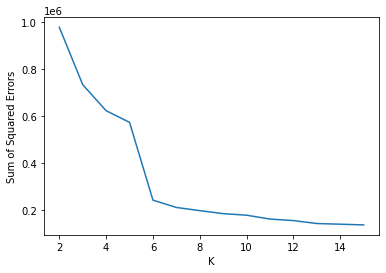

In [61]:
kprotos = run_kprototypes(speakers_features_preprocessed, start=2, end=15)
plot_sse(kprotos)

### Check distribution of elements among clusters

In [67]:
def print_cluster_labels(kprotos):
    """Print cluster labels to see distribution of elements among them."""
    for k, kproto in kprotos.items():
        print(f'k = {k} --> {Counter(kproto.labels_)}')
print_cluster_labels(kprotos)

k = 2 --> Counter({1: 2516, 0: 1990})
k = 3 --> Counter({1: 2146, 2: 1439, 0: 921})
k = 4 --> Counter({1: 1731, 0: 1295, 3: 1227, 2: 253})
k = 5 --> Counter({4: 1398, 0: 1074, 1: 1018, 3: 841, 2: 175})
k = 6 --> Counter({3: 1360, 4: 1216, 2: 880, 5: 718, 1: 331, 0: 1})
k = 7 --> Counter({6: 1151, 4: 994, 5: 807, 3: 759, 2: 606, 1: 188, 0: 1})
k = 8 --> Counter({1: 906, 5: 809, 6: 688, 7: 675, 2: 651, 4: 602, 0: 174, 3: 1})
k = 9 --> Counter({4: 1003, 8: 903, 0: 729, 3: 600, 5: 543, 7: 536, 1: 188, 6: 3, 2: 1})
k = 10 --> Counter({4: 911, 6: 764, 9: 636, 1: 543, 3: 470, 7: 432, 0: 391, 5: 234, 8: 124, 2: 1})
k = 11 --> Counter({8: 647, 5: 625, 6: 580, 4: 533, 3: 515, 1: 511, 2: 486, 0: 406, 9: 186, 10: 16, 7: 1})
k = 12 --> Counter({0: 837, 10: 647, 1: 589, 9: 469, 5: 418, 2: 413, 8: 389, 11: 379, 7: 214, 3: 135, 4: 15, 6: 1})
k = 13 --> Counter({11: 837, 9: 647, 0: 589, 8: 538, 4: 441, 1: 406, 12: 390, 10: 294, 6: 210, 2: 135, 3: 15, 7: 3, 5: 1})
k = 14 --> Counter({10: 837, 8: 647, 6:

### 5. Visualize clusters distributions for k=6

In [62]:
def get_cluster_points(features, labels):
    """
    Given the features clustered over and the resulting labels, return dataframes
    where each dataframe contains the points of a label.
    -----
    Input: features - the dataframe which the clustering was run for
           labels   - the labels that each row of features received on clustering
    Returns:
           list_of_dfs - a list of dataframes, where each dataframe contains the points
                         of a same cluster label.
    """
    unique_classes = np.unique(labels)
    list_of_dfs = []
    for label in unique_classes:
        class_filter = np.equal(label, labels) * 1
        indices = np.nonzero(class_filter)
        df = features.iloc[indices]
        list_of_dfs.append(df)
    return list_of_dfs

clusters_for_k_6 = get_cluster_points(speakers_features_preprocessed, kprotos[6].labels_)

In [107]:
from qwikidata.linked_data_interface import get_entity_dict_from_api
from qwikidata.entity import WikidataItem
import itertools

def plot_occupation_of_clusters(clusters, nr_occupations=5):
    """
    Input: clusters - list of dataframes, where each dataframe contains points of the same cluster label.
    """
    nr_clusters = len(clusters)
    _, axs = plt.subplots(1, 6, figsize=(22, 8), sharey=True)

    for i, df in enumerate(clusters):
        # Get the qids from the quotations df:
        qids = df.index.tolist()
        # Get the rows of the speakers having the wanted qids
        speakers = wikidata_speakers.loc[qids]
        # Get the speakers occupations and count them
        occupation_ids = [occ_id[0] for occ_id in speakers.occupation.values if not occ_id is None]
        occupation_count = Counter(occupation_ids)
        occupation_count_sorted = dict(sorted(occupation_count.items(), key=lambda x: x[1], reverse=True)) 
        top_occupations = dict(itertools.islice(occupation_count_sorted.items(), nr_occupations)) 
        # Query wikidata for occupation labels
        top_occupations_labels = [get_entity_dict_from_api(item)['labels']['en']['value'] for item in top_occupations.keys()]
        # Plot
        _ = axs[i].set_title(f'Cluster {i+1}')
        _ = axs[i].bar(top_occupations.keys(), top_occupations.values(), color='g', log=False, alpha=0.6)
        _ = axs[i].set_xticklabels(top_occupations_labels)
        _ = plt.setp(axs[i].get_xticklabels(), fontsize=12, rotation=55, ha='right')


<ipython-input-107-b5f0fcb76a9a>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axs[i].set_xticklabels(top_occupations_labels)


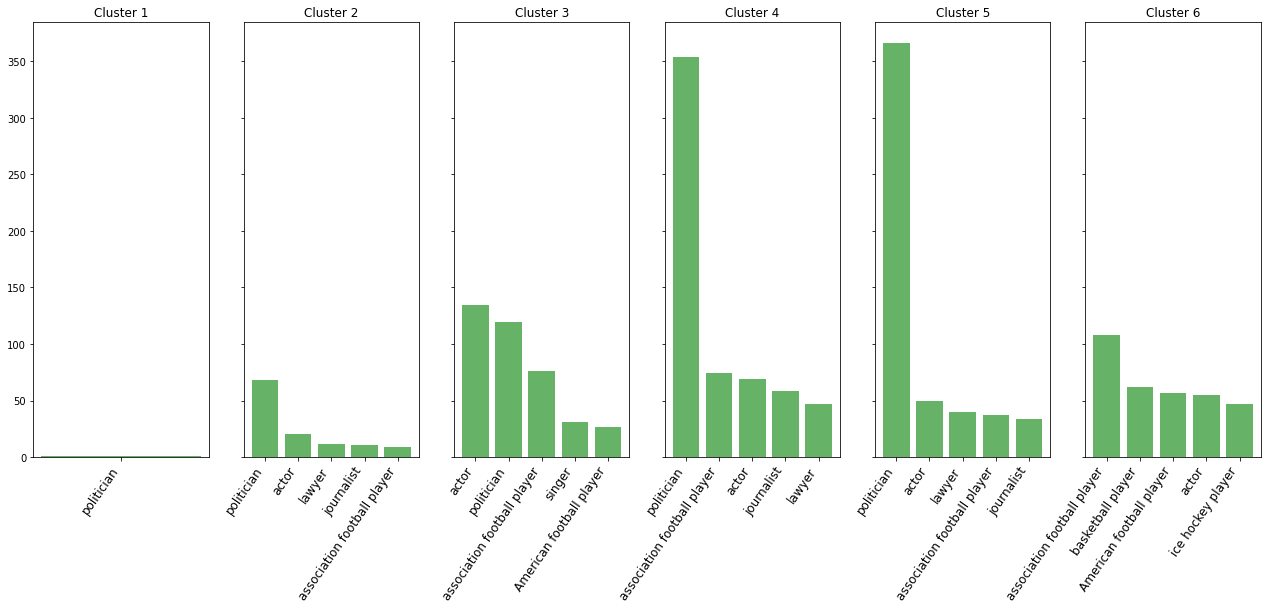

In [108]:
plot_occupation_of_clusters(clusters_for_k_6)

In [109]:
def plot_nationality_of_clusters(clusters, nr_nationalities=5):
    """
    Input: clusters - list of dataframes, where each dataframe contains points of the same cluster label.
    """
    nr_clusters = len(clusters)
    _, axs = plt.subplots(1, 6, figsize=(22, 8), sharey=True)

    for i, df in enumerate(clusters):
        # Get the qids from the quotations df:
        qids = df.index.tolist()
        # Get the rows of the speakers having the wanted qids
        speakers = wikidata_speakers.loc[qids]
        # Get the speakers occupations and count them
        nationality_ids = [nat[0] for nat in speakers.nationality.values if not nat is None]
        nationality_count = Counter(nationality_ids)
        nationality_count_sorted = dict(sorted(nationality_count.items(), key=lambda x: x[1], reverse=True)) 
        top_nationalities = dict(itertools.islice(nationality_count_sorted.items(), nr_nationalities)) 

        # Query wikidata for occupation labels
        top_nationality_labels = [get_entity_dict_from_api(item)['labels']['en']['value'] for item in top_nationalities.keys()]
        # Plot
        _ = axs[i].set_title(f'Cluster {i+1}')
        _ = axs[i].bar(top_nationalities.keys(), top_nationalities.values(), color='b', log=False, alpha=0.6)
        _ = axs[i].set_xticklabels(top_nationality_labels)
        _ = plt.setp(axs[i].get_xticklabels(), fontsize=12, rotation=55, ha='right')


<ipython-input-109-1dca1dd63e07>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axs[i].set_xticklabels(top_nationality_labels)


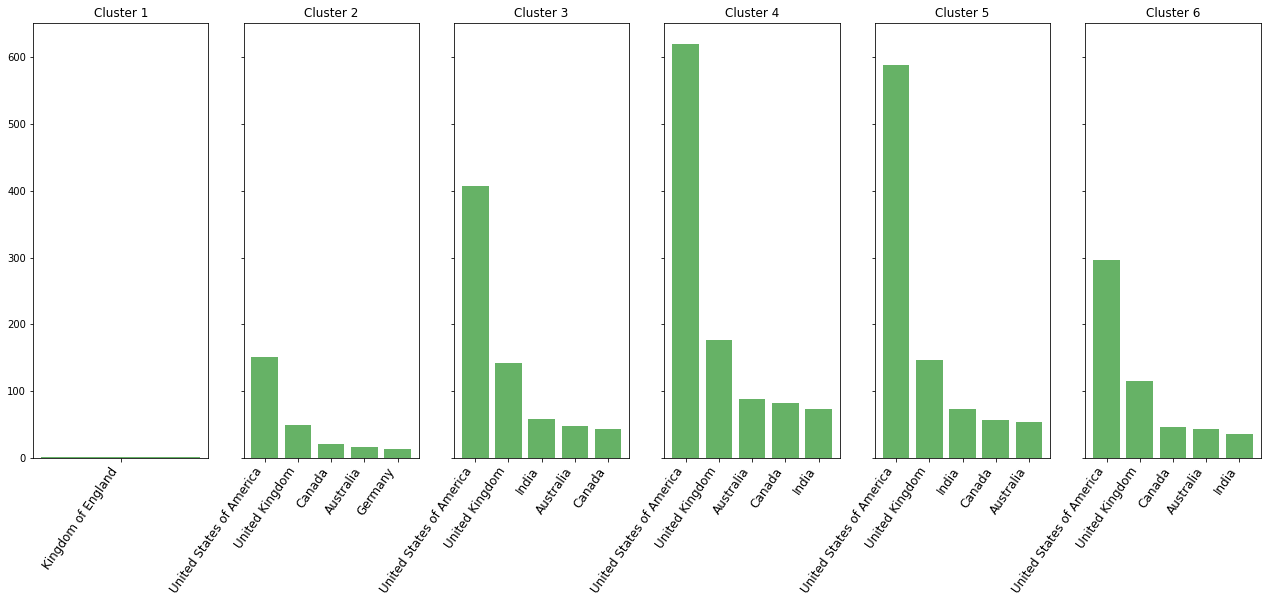

In [110]:
plot_nationality_of_clusters(clusters_for_k_6)

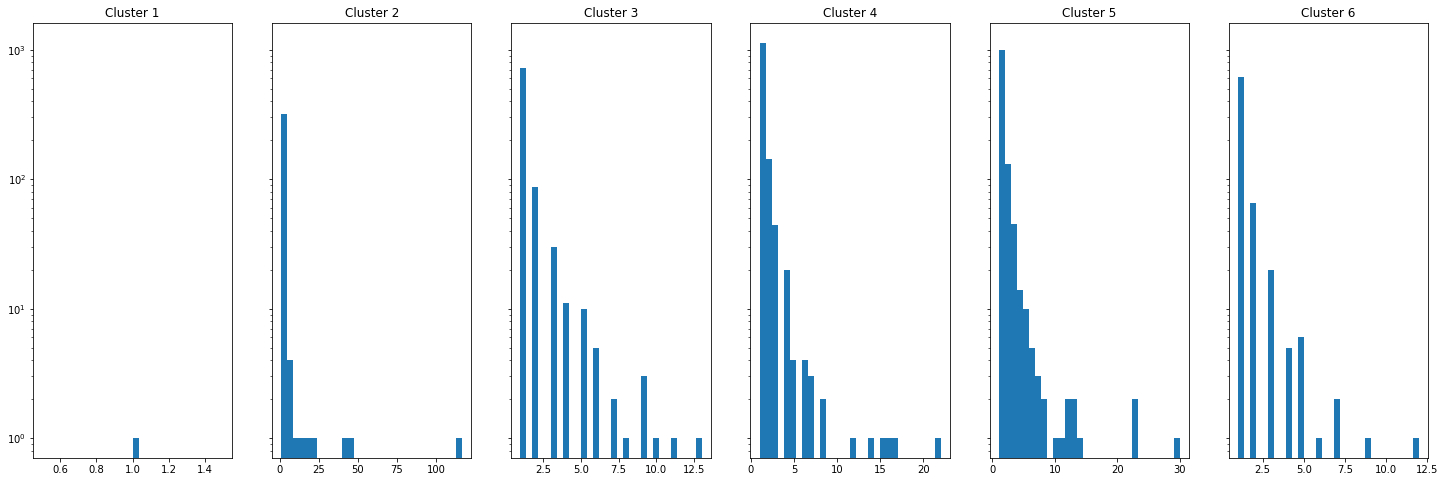

In [125]:
def plot_nr_quotes_of_clusters(clusters):
    # plt.bar(range(1, len(clusters) + 1), [cluster_df.n_quotes.sum() for cluster_df in clusters])
    # plt.xlabel('Cluster number')
    # plt.ylabel('Number of quotations')
    _, axs = plt.subplots(1, 6, figsize=(25, 8), sharey=True)
    for i, cluster_df in enumerate(clusters):
        axs[i].hist(cluster_df.n_quotes, bins=30, log=True)
        axs[i].set_title(f'Cluster {i+1}')
plot_nr_quotes_of_clusters(clusters_for_k_6)

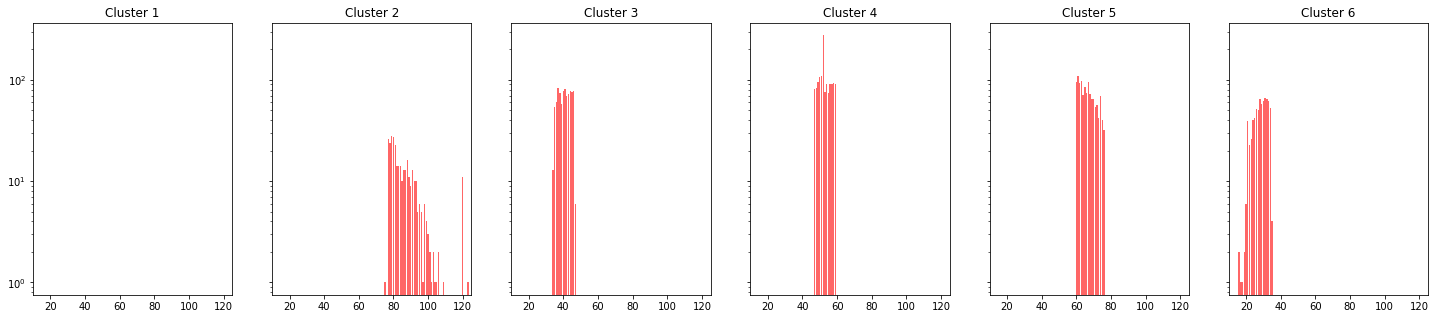

In [140]:
def plot_age_of_clusters(clusters):
    """
    Input: clusters - list of dataframes, where each dataframe contains points of the same cluster label.
    """
    _, axs = plt.subplots(1, 6, figsize=(25, 5), sharey=True)
    for i, cluster_df in enumerate(clusters):
        ages_count = Counter(cluster_df.age)
        # axs[i].hist(cluster_df.n_quotes, bins=30)
        _ = axs[i].set_title(f'Cluster {i+1}') 
        _ = axs[i].set_xlim(10, 125)
        _ = axs[i].bar(ages_count.keys(), ages_count.values(), color='r', log=True, alpha=0.6, width=0.8)
plot_age_of_clusters(clusters_for_k_6)

In [ ]:
def plot_ethnicity_of_clusters(clusters, nr_ethnicities=5):
    """
    Input: clusters - list of dataframes, where each dataframe contains points of the same cluster label.
    """
    _, axs = plt.subplots(1, 6, figsize=(22, 8), sharey=True)

    for i, df in enumerate(clusters):
        # Get the qids from the quotations df:
        qids = df.index.tolist()
        # Get the rows of the speakers having the wanted qids
        speakers = wikidata_speakers.loc[qids]

        ethnic_ids = [ethnic_id[0] for ethnic_id in speakers.ethnic_group.values if ethnic_id is not None]
        ethnic_count = Counter(ethnic_ids)

        # Manual grouping of the top 20 ethnicity groups into: black, white and asian (ethnicities that American companies normally use)
        ethnic_count_manual = {'black':  ethnic_count['Q49085'] + ethnic_count['Q190168'] + ethnic_count['Q244157'] + 
                                        ethnic_count['Q33938'] + ethnic_count['Q129962'],
                            
                            'white':  ethnic_count['Q7325'] + ethnic_count['Q678551'] + ethnic_count['Q2325516'] + 
                                        ethnic_count['Q170826'] + ethnic_count['Q974693'] + ethnic_count['Q1075293'] + 
                                        ethnic_count['Q42406'] + ethnic_count['Q842438'] + ethnic_count['Q49078'] + 
                                        ethnic_count['Q79797'] + ethnic_count['Q7994501'] + ethnic_count['Ashkenazi Jews'],
                            
                            'asians': ethnic_count['Q932244'] + ethnic_count['Q854323'] + ethnic_count['Q862086'],
                            
                            'indigeneous': 0
                            }

        ethnic_count_sorted = dict(sorted(ethnic_count_manual.items(), key=lambda x: x[1], reverse=True)) 
        top_ethnicities = dict(itertools.islice(ethnic_count_sorted.items(), nr_ethnicities)) 

        # Plot
        _ = axs[i].set_title(f'Cluster {i+1}')
        _ = axs[i].bar(top_ethnicities.keys(), top_ethnicities.values(), color='b', log=False, alpha=0.6)
        _ = axs[i].set_xticklabels(top_ethnicities)
        _ = plt.setp(axs[i].get_xticklabels(), fontsize=12, rotation=55, ha='right')

